In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [66]:
df_france = pd.read_csv("France.csv")
df_france["country"] = "France"
df_chile = pd.read_csv("Chile.csv").rename(columns={"Household Income": "Median Income"})
df_chile["country"] = "Chile"

df_us = pd.read_csv("United States.csv").rename(columns={"Household Income": "Median Income"})
df_us = df_us.drop(columns=["Personal Income"])
df_us["country"] = "United States"

df = pd.concat([df_france, df_chile, df_us])
# df = df.reset_index(drop=True)
# dd = df.groupby("country").corr().reset_index()
# dd = dd.melt(id_vars=["country", "level_1"])
# df = df.dropna()
df = df.rename(columns={"Gini": "Inequality level (Gini)"})
df = df.rename(columns={"EPI": "EP", "Within-EPI": "Within-EP", "Between-EPI": "Between-EP"})
df = df[df["state"] != "DISTRICT OF COLUMBIA"]
df.head()

,EP,Between-EP,Within-EP,Inequality level (Gini),Median Income,Rurality (%),Poverty (%),country,state
0,0.899334,0.867431,0.031903,0.358,23650.0,0.330,10.3,France,NaN
1,0.877552,0.844325,0.033227,0.351,19310.0,0.468,18.4,France,NaN
2,0.903462,0.871383,0.032079,0.329,19990.0,0.417,15.5,France,NaN
3,0.901569,0.870461,0.031109,0.340,20430.0,0.381,16.8,France,NaN
4,0.906952,0.876235,0.030717,0.318,20760.0,0.405,13.9,France,NaN


In [67]:
columns = ["EP", "Within-EP", "Between-EP", "Inequality level (Gini)", "Median Income", "Rurality (%)", "Poverty (%)"]
output = []
for idx, dt in df.groupby("country"):
    for var_a in columns:
        for var_b in columns:

            pp = scipy.stats.pearsonr(dt[var_a], dt[var_b])
            value, pvalue = pp
            lcl, ucl = pp.confidence_interval(confidence_level=0.95)

            output.append({
                "country": idx,
                "lcl": lcl,
                "ucl": ucl,
                "value": value,
                "pvalue": pvalue,
                "level_0": var_a,
                "variable": var_b
            })   

dd = pd.DataFrame(output)
dd

,country,lcl,ucl,value,pvalue,level_0,variable
0,Chile,1.000000,1.000000,1.000000,0.000000e+00,EP,EP
1,Chile,-0.139811,0.757726,0.401185,1.383172e-01,EP,Within-EP
2,Chile,0.685922,0.961980,0.886643,1.064606e-05,EP,Between-EP
3,Chile,-0.613542,0.394403,-0.147701,5.993655e-01,EP,Inequality level (Gini)
4,Chile,-0.633849,0.365970,-0.180047,5.208048e-01,EP,Median Income
...,...,...,...,...,...,...,...
142,United States,-0.476115,0.053780,-0.227980,1.113089e-01,Poverty (%),Between-EP
143,United States,0.380120,0.749573,0.595464,5.079678e-06,Poverty (%),Inequality level (Gini)
144,United States,-0.932880,-0.803483,-0.884103,1.779991e-17,Poverty (%),Median Income
145,United States,-0.058495,0.472449,0.223491,1.187222e-01,Poverty (%),Rurality (%)


In [68]:
dd[(dd["level_0"] == "Within-EP") & ~(dd["variable"].isin(["EP", "Within-EP", "Between-EP"])) & (dd["country"] == "United States")]

,country,lcl,ucl,value,pvalue,level_0,variable
108,United States,-0.142592,0.403824,0.141367,0.327451,Within-EP,Inequality level (Gini)
109,United States,-0.470579,0.060891,-0.221206,0.122637,Within-EP,Median Income
110,United States,-0.167893,0.381900,0.115870,0.422955,Within-EP,Rurality (%)
111,United States,-0.002056,0.515157,0.276450,0.051966,Within-EP,Poverty (%)


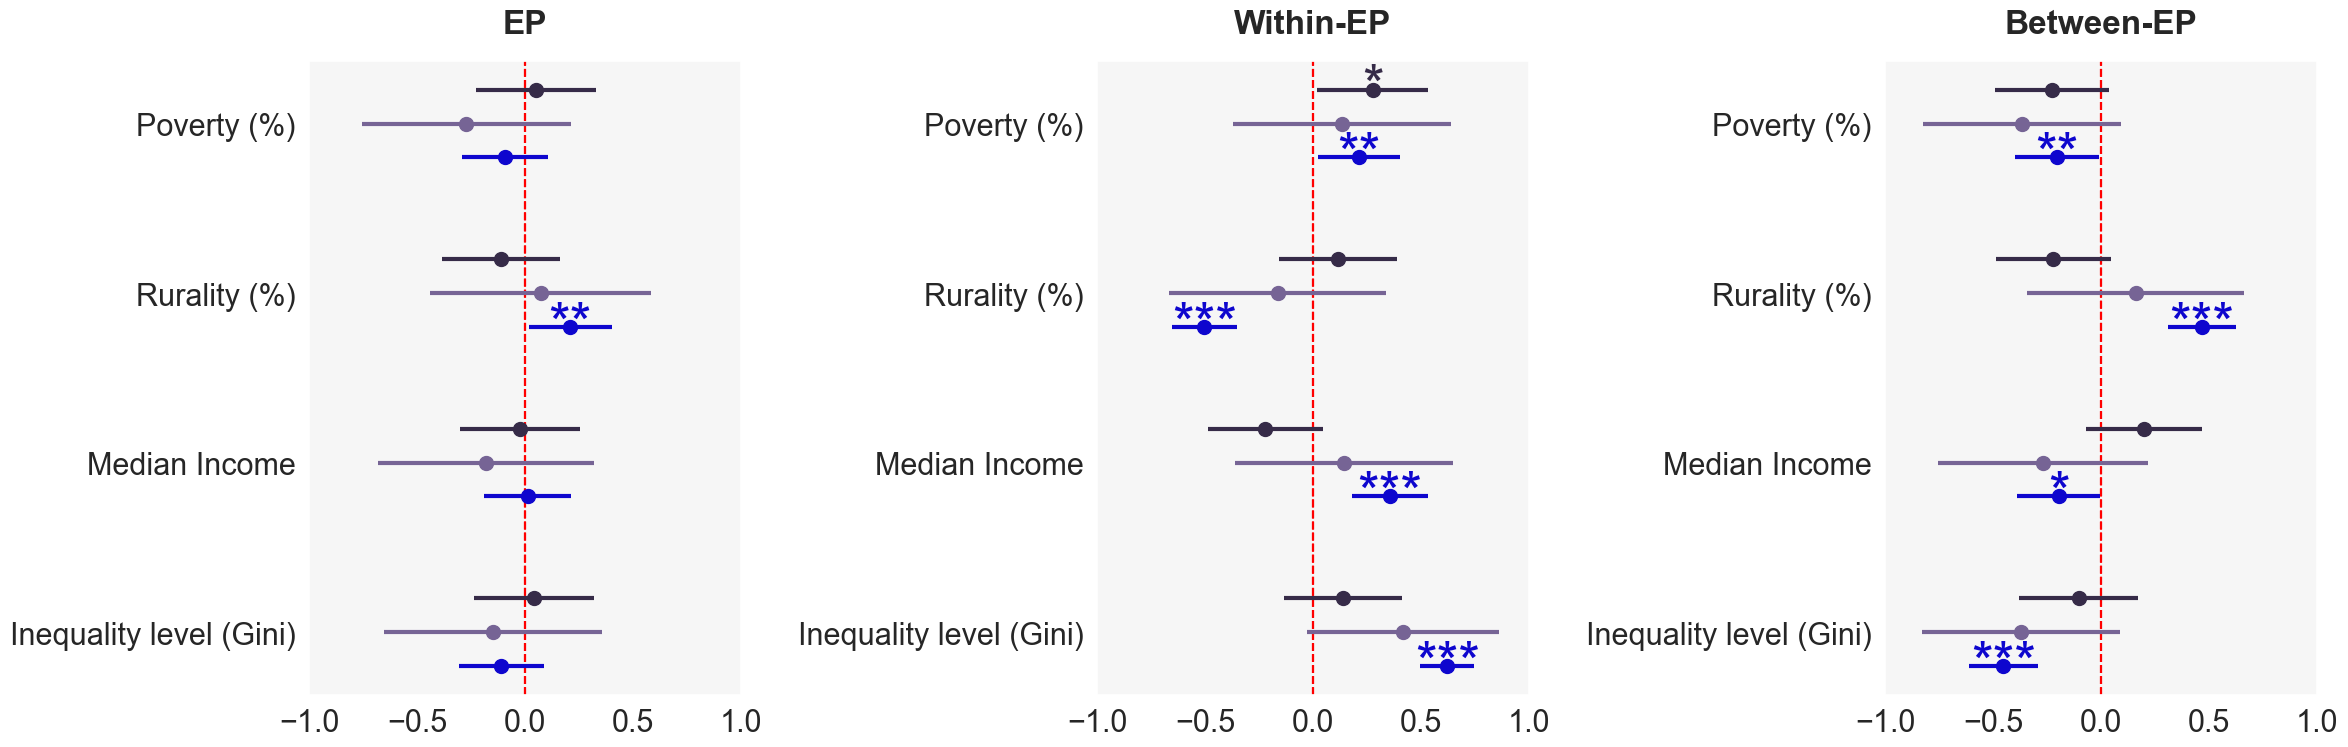

In [69]:
from matplotlib.transforms import Affine2D
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

variable = "EP"
colors = ["#0E06CE", "#766495", "#362B48"]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

for ii, variable in enumerate(["EP", "Within-EP", "Between-EP"]):
    ax = axs[ii]

    for idc, country in enumerate(["France", "Chile", "United States"]):
        
        data = dd[(dd["level_0"] == variable) & ~(dd["variable"].isin(["EP", "Within-EP", "Between-EP"])) & (dd["country"] == country)]
        # display(data)
        x = data["value"].values
        y = data["variable"].values
        xerr = (data["ucl"] - data["lcl"]).values / 2

        v = 0
        if country == "France":
            v = -0.2
        elif country == "United States":
            v = 0.2
        trans1 = Affine2D().translate(0.0, v) + ax.transData

        ax.errorbar(x, y, xerr=xerr, elinewidth=3, markersize=10, color=colors[idc], linestyle="", marker="o", zorder=99, transform=trans1)
        for idx, item in data.iterrows():
            if item["pvalue"] < 0.01:
                pval = "***"
            elif item["pvalue"] < 0.05:
                pval = "**"
            elif item["pvalue"] < 0.1:
                pval = "*"
            else:
                pval = ""
            
            
            ax.text(item["value"], item["variable"], pval, va="center", fontsize=40, color=colors[idc], ha="center", transform=trans1)

        ax.axvline(x=0, ls="--", zorder=1, color="red")
        ax.set_xlim(-1, 1)
        ax.set_title(variable, fontweight="bold", pad=20)

fig.tight_layout()

In [70]:
df[df["country"]=="France"]

,EP,Between-EP,Within-EP,Inequality level (Gini),Median Income,Rurality (%),Poverty (%),country,state
0,0.899334,0.867431,0.031903,0.358,23650.0,0.330,10.3,France,NaN
1,0.877552,0.844325,0.033227,0.351,19310.0,0.468,18.4,France,NaN
2,0.903462,0.871383,0.032079,0.329,19990.0,0.417,15.5,France,NaN
3,0.901569,0.870461,0.031109,0.340,20430.0,0.381,16.8,France,NaN
4,0.906952,0.876235,0.030717,0.318,20760.0,0.405,13.9,France,NaN
...,...,...,...,...,...,...,...,...,...
91,0.898915,0.855077,0.043838,0.353,24490.0,0.039,13.1,France,NaN
92,0.887548,0.839126,0.048422,0.435,30470.0,0.000,11.9,France,NaN
93,0.867059,0.825797,0.041261,0.411,16600.0,0.000,28.4,France,NaN
94,0.892551,0.846536,0.046014,0.401,23530.0,0.000,16.6,France,NaN


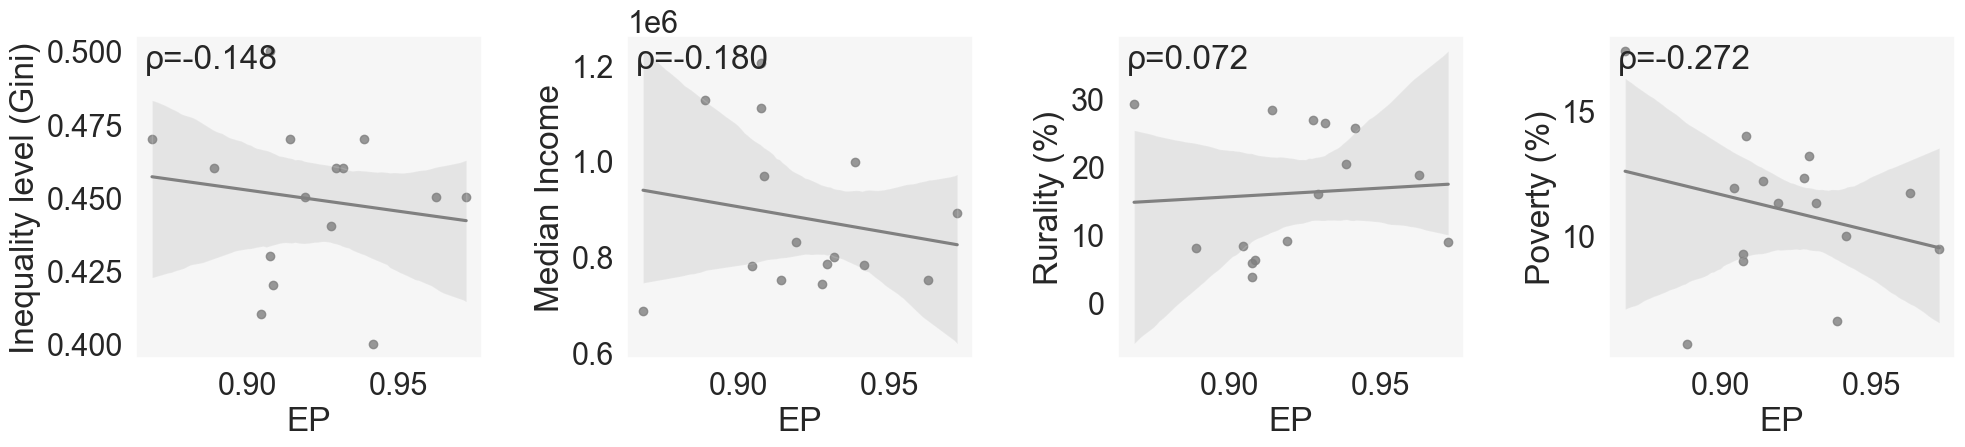

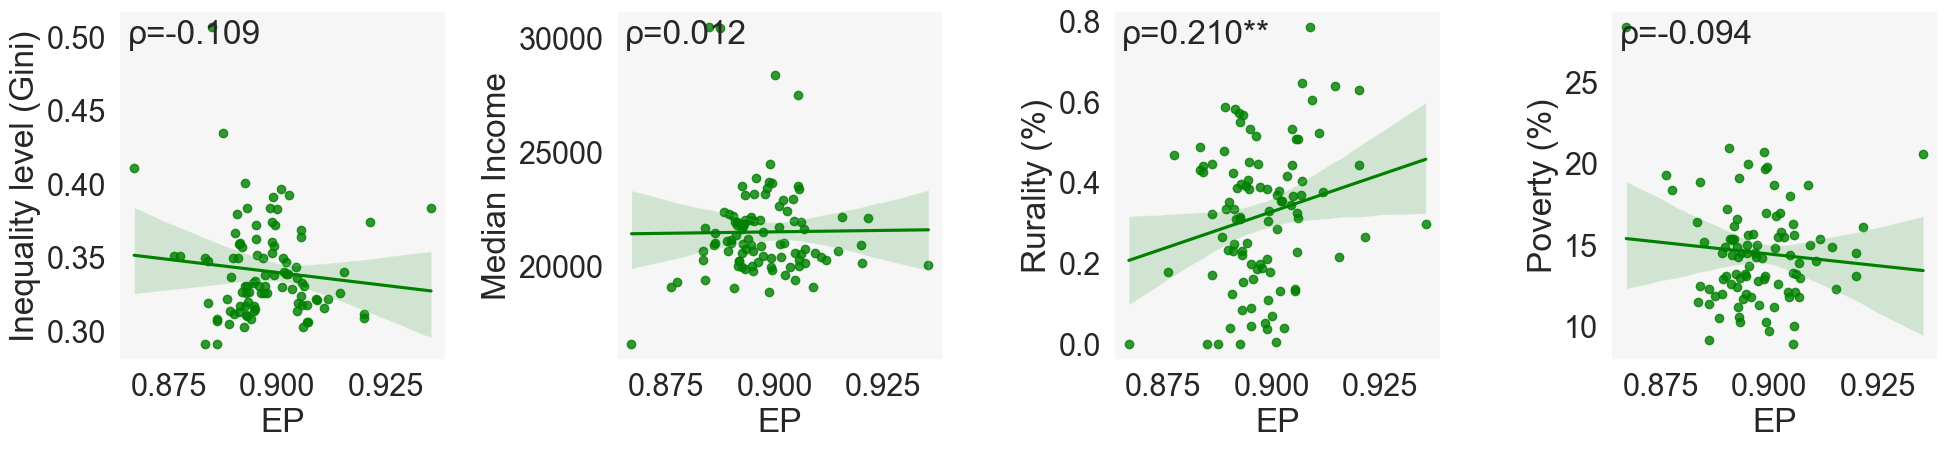

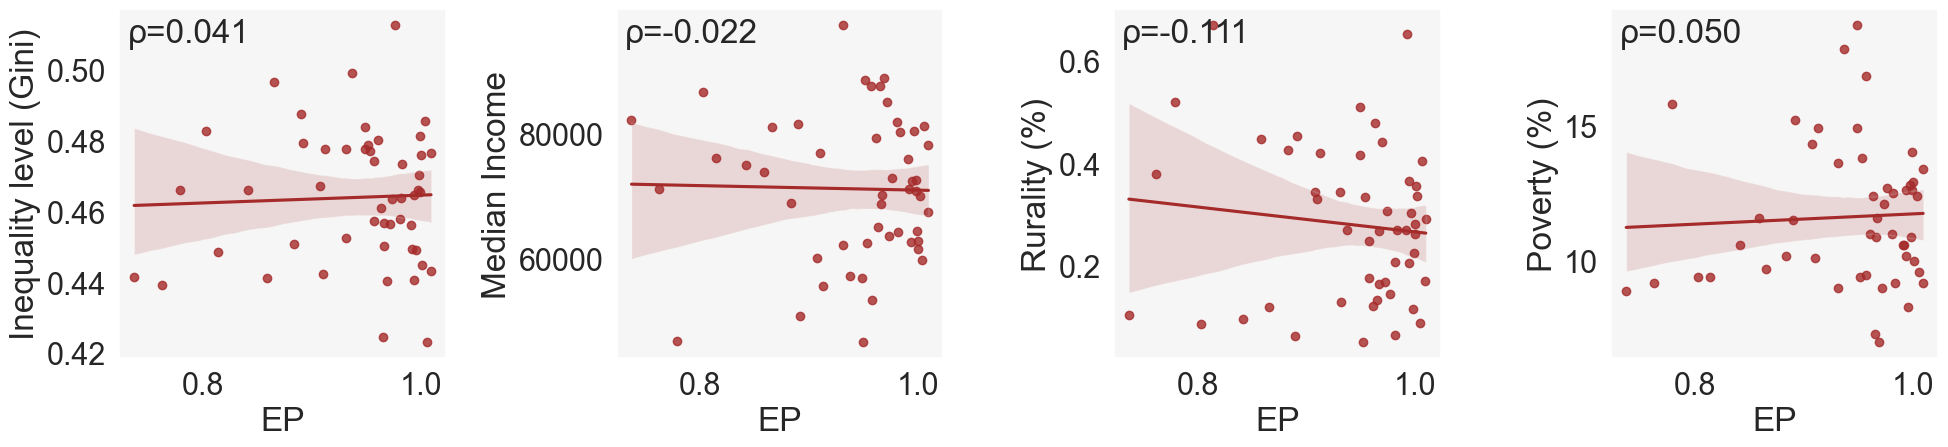

In [75]:
x = "EP"
y = "Inequality level (Gini)" #Median Income Rurality (%) Poverty (%)
# y = "Median Income"
country = "France"

colors = {
    "France": "green",
    "Chile": "gray",
    "United States": "brown"
}



i = 0
for country in ["Chile", "France", "United States"]:
    data = df[df["country"] == country]
    j = 0
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

    for y in ["Inequality level (Gini)", "Median Income", "Rurality (%)", "Poverty (%)"]:
        ax = axs[j]
        j += 1
        sns.regplot(x=x, y=y, line_kws={"color": colors[country]}, scatter_kws={"color": colors[country]}, data=data, ax=ax)

        def corrfunc(value, pvalue):
            ax = plt.gca()
            note = ""
            if pvalue < 0.001:
                note = "***"
            elif pvalue < 0.05:
                note = "**"
            elif pvalue < 0.1:
                note = "*"

            return f"ρ=" + "{:.3f}{}".format(value, note)

        value, pvalue = scipy.stats.pearsonr(data[x], data[y])
        ax.text(0.025, 0.975, corrfunc(value, pvalue), va="top", transform=ax.transAxes)

    fig.tight_layout()
    i += 1


In [72]:
# sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

# variable = "Within-EP"
# data = dd[(dd["level_0"] == variable) & ~(dd["variable"].isin(["EP", "Within-EP", "Between-EP"]))]
# fig, ax = plt.subplots(figsize=(7, 6))
# g = sns.pointplot(y="variable", x="value", dodge=0.35, join=False, hue="country", errorbar=(data["lcl"], data["ucl"]),
#                   data=data)

# ax.legend(loc="center left", shadow=False, bbox_to_anchor=(1, 0.5))

# g.axvline(x=0, ls="--", color="red")
# g.set_xlim(-1, 1)